# Feature Engineering

This notebook is a natural continuation of the exploratory data analysis in the Exploratory_Data_Analysis notebook.

Key findings from the EDA were:
- Missing values are relatively frequent, so a solution for nulls should be considered
- The two cities that the measurements are taken from have:
    - Different (hard to measure how different without more data..) climates according to the weather data
    - Have different train and test time measurement periods. And the test period immediately follows the training period for each city
        - This means the problem can be considered as a forecasting one, for each city. 
        - Initial feelings are that the model should condition for each city.
        
- Quarterly seasonality of total cases
- Strong autocorrelation of cases (previous weeks' case rate will be good predictor of the future)
            
- A quick peek of raw feature predictive power suggest that weekofyear, humidity, rain and temperature could be important in the model.

The purpose of this notebook will be to engineer features from the raw data to use in the final model. This will be a combination of:
- Intuition (e.g. time/seasonal related feature construction)
- Using SKLearn to create PCA and Polynomial features
- Use SKLearn to build a tunable feauture construction pipeline, with normalising, scaling and adding of other features.

We will construct a large number of features, with the regularisation/feature selection part left as part of the model building/benchmarking process


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
cwd = os.getcwd().split('\\')
local_repo_path = '\\'.join(cwd[:-1])
raw_data_path = local_repo_path + r'\data\raw'
processed_data_path = local_repo_path + '\data\processed'
feature_path = local_repo_path + r'\\data\\features'

In [3]:
train = pd.read_csv(processed_data_path + r'\train_dataset.csv', index_col = 0)
test = pd.read_csv(raw_data_path + r'\dengue_features_test.csv', index_col = None)
combined = pd.read_csv(processed_data_path + r'\combined_train_test_dataset.csv', index_col = 0)

## Add quarter and month columns to data

In [4]:
train['quarter'] = pd.to_datetime(train['week_start_date']).map(lambda x: x.quarter)
test['quarter'] = pd.to_datetime(test['week_start_date']).map(lambda x: x.quarter)
train['month'] = pd.to_datetime(train['week_start_date']).map(lambda x: x.month)
test['month'] = pd.to_datetime(test['week_start_date']).map(lambda x: x.month)

## Cases by quarter

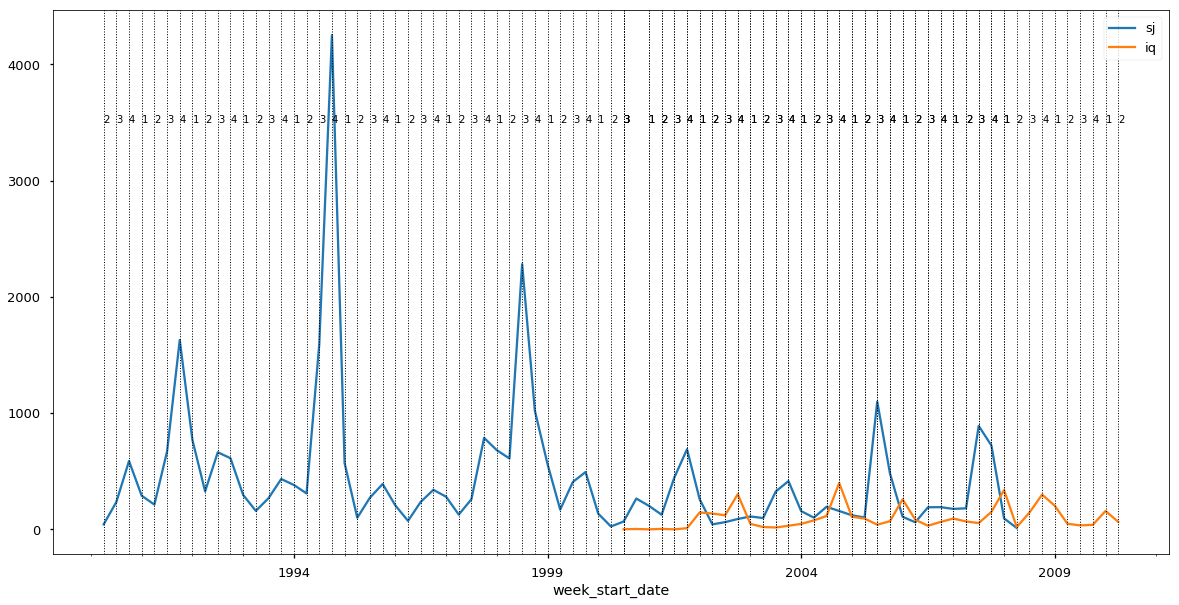

In [5]:
fig, ax = plt.subplots(figsize = (20,10))
train[train['city'] == 'sj'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'sj']['week_start_date'])).groupby(pd.Grouper(freq='Q')).sum().plot(ax = ax)
train[train['city'] == 'iq'][['week_start_date', 'total_cases']].set_index(pd.DatetimeIndex(train[train['city'] == 'iq']['week_start_date'])).groupby(pd.Grouper(freq='Q')).sum().plot(ax = ax)
ax.legend(labels = ['sj', 'iq'])
for i, d in enumerate(train['weekofyear']):
    if np.mod(d,13) == 0 or d == 53:
        ax.axvline(train['week_start_date'].values[i], color = 'black', linewidth = 1, linestyle = 'dotted')
        ax.text(train['week_start_date'].values[i], 3500, train['quarter'][i])

# Time related features

# Add polynomial fits as features.. & illustrate their predictive power

In [16]:
weekly_cases_iq = train[train['city'] == 'iq'][['weekofyear', 'total_cases']].groupby('weekofyear').mean()
pfit2 = np.polyfit(weekly_cases_iq.index[:-2], weekly_cases_iq['total_cases'][:-2], deg = 2)
p2 = np.poly1d(pfit2)

In [17]:
weekly_cases_sj = train[train['city'] == 'sj'][['weekofyear', 'total_cases']].groupby('weekofyear').mean()
pfit6 = np.polyfit(weekly_cases_sj.index, weekly_cases_sj['total_cases'], deg = 6)
p6 = np.poly1d(pfit6)

In [18]:
sj_poly_train = p6(weekly_cases_sj.index)
iq_poly_train = p2(weekly_cases_iq.index)
sj_poly_test = p6(weekly_cases_sj.index)
iq_poly_test = p2(weekly_cases_iq.index)
train['poly_fit'] = 0
for i in (weekly_cases_sj.index):
    mask = (train.city == 'sj') & (train.weekofyear == i)
    train.loc[mask, 'poly_fit'] = sj_poly_train[i-1]
    mask = (test.city == 'sj') & (test.weekofyear == i)
    test.loc[mask, 'poly_fit'] = sj_poly_test[i-1]
    mask = (train.city == 'iq') & (train.weekofyear == i)
    train.loc[mask, 'poly_fit'] = iq_poly_train[i-1]
    mask = (test.city == 'iq') & (test.weekofyear == i)
    test.loc[mask, 'poly_fit'] = iq_poly_test[i-1]

In [19]:
train_sj = train[train['city'] == 'sj']
test_sj = test[test['city']=='sj']
train_iq = train[train['city'] == 'iq'].reset_index().drop('index', axis = 1)
test_iq = test[test['city'] == 'iq'].reset_index().drop('index', axis = 1)

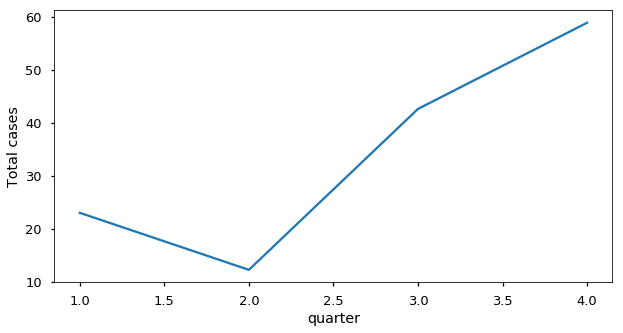

In [20]:
fig, ax = plt.subplots(figsize = (10,5))
train_sj[['quarter', 'total_cases']].groupby('quarter').agg(['mean']).plot(ax = ax)
ax.set_ylabel('Total cases')
ax.legend().set_visible(False)

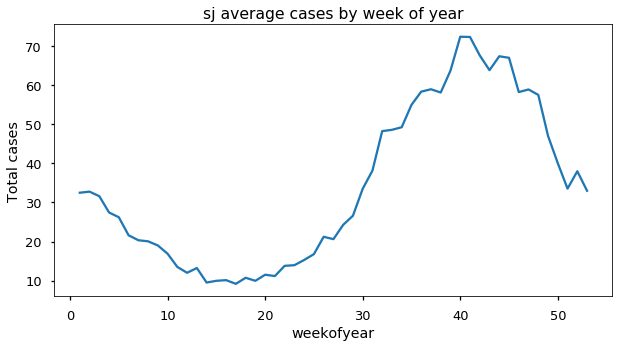

In [21]:
fig, ax = plt.subplots(figsize = (10,5));
train_sj[['weekofyear', 'total_cases']].groupby('weekofyear').agg(['mean']).plot(ax = ax);
ax.set_ylabel('Total cases');
ax.legend().set_visible(False);
ax.set_title('sj average cases by week of year');

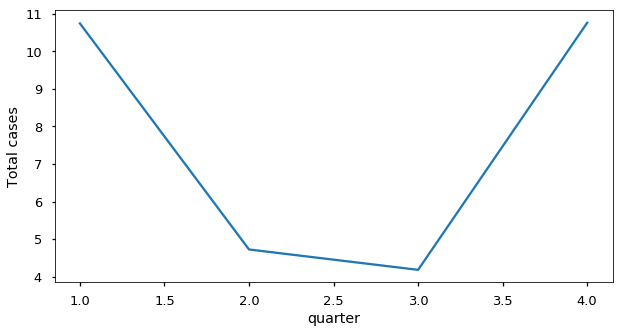

In [22]:
fig, ax = plt.subplots(figsize = (10,5))
train_iq[['quarter', 'total_cases']].groupby('quarter').agg(['mean']).plot(ax = ax)
ax.set_ylabel('Total cases')
ax.legend().set_visible(False)

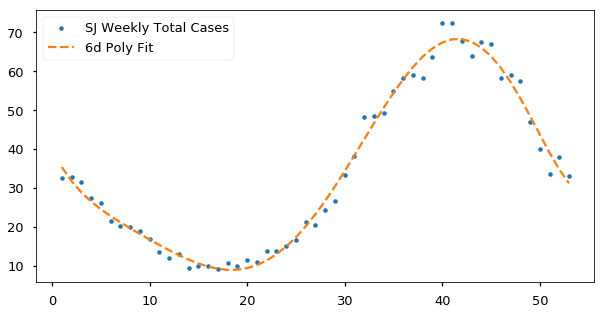

In [23]:
fig, ax = plt.subplots(figsize = (10,5));
ax.plot(weekly_cases_sj.index, weekly_cases_sj['total_cases'], '.', label = 'SJ Weekly Total Cases');
ax.plot(weekly_cases_sj.index, p6(weekly_cases_sj.index), '--', label = '6d Poly Fit');
ax.legend()

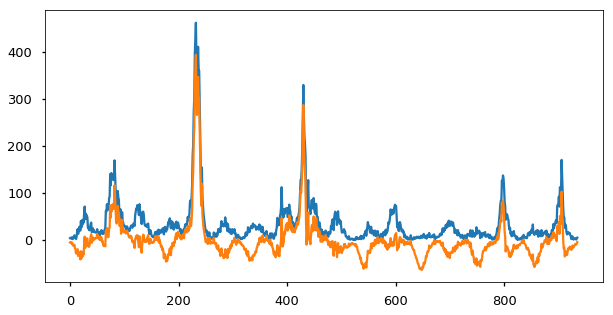

In [24]:
fig, ax = plt.subplots(figsize = (10,5));
ax.plot(train[train['city'] == 'sj'].index, train[train['city'] == 'sj']['total_cases'])
ax.plot(train[train['city'] == 'sj'].index, train[train['city'] == 'sj']['total_cases'] - p6(train[train['city'] == 'sj']['weekofyear']))

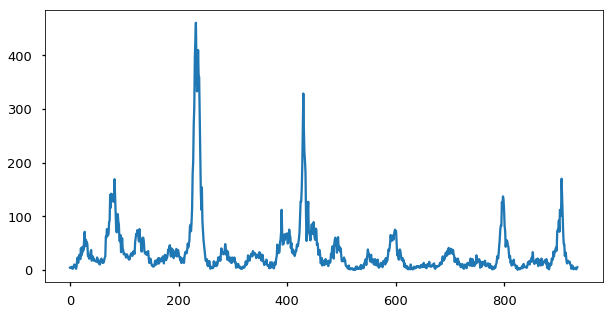

In [25]:
fig, ax = plt.subplots(figsize = (10,5));
ax.plot(train[train['city'] == 'sj'].index, train[train['city'] == 'sj']['total_cases'])

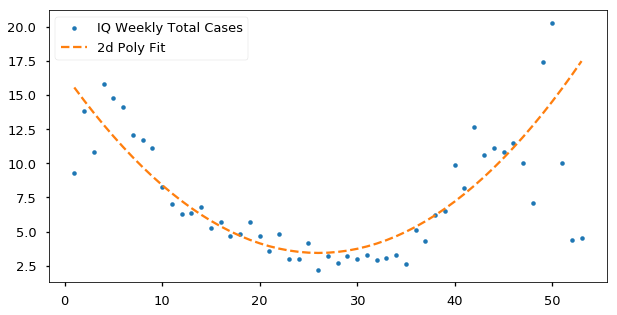

In [26]:
fig, ax = plt.subplots(figsize = (10,5));
ax.plot(weekly_cases_iq.index, weekly_cases_iq['total_cases'], '.', label = 'IQ Weekly Total Cases');
ax.plot(weekly_cases_iq.index, p2(weekly_cases_iq.index), '--', label = '2d Poly Fit');
ax.legend();

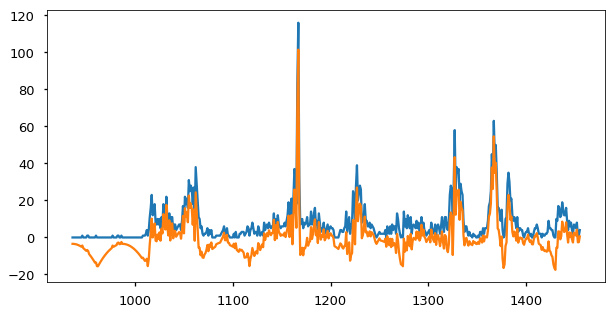

In [27]:
fig, ax = plt.subplots(figsize = (10,5));
ax.plot(train[train['city'] == 'iq'].index, train[train['city'] == 'iq']['total_cases'])
ax.plot(train[train['city'] == 'iq'].index, train[train['city'] == 'iq']['total_cases'] - p2(train[train['city'] == 'iq']['weekofyear']))

In [28]:
train_sj.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,quarter,month,poly_fit
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,2,4,9.039287
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,2,5,9.081744
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,2,5,9.477176
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,2,5,10.252293
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,2,5,11.426181


In [29]:
train_iq.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,quarter,month,poly_fit
0,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,8.928571,26.400000,10.775000,32.5,20.7,3.0,0,3,7,3.438560
1,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,10.314286,26.900000,11.566667,34.0,20.8,55.6,0,3,7,3.456391
2,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,7.385714,26.800000,11.466667,33.0,20.7,38.1,0,3,7,3.512889
3,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,9.114286,25.766667,10.533333,31.5,14.7,30.0,0,3,7,3.608054
4,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,9.500000,26.600000,11.480000,33.3,19.1,4.0,0,3,7,3.741885


# Feature pipeline

- Create pipeline that constructs (the same) features for 
   - train_sj & test_sj
   - train_iq & test_iq

In [83]:
numeric_cols = combined.select_dtypes(include=[np.number]).drop(['year', 'weekofyear'], axis = 1).columns.tolist()
numeric_cols

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

In [75]:
best_raw_features = ['reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k', 'station_avg_temp_c', 'station_min_temp_c', 'poly_fit']

In [85]:
categorical_cols = ['month','weekofyear']

In [88]:
from SKL_search import *
from sklearn.preprocessing import OneHotEncoder
def feature_pipeline(df_train, df_test, numeric_cols, categorical_cols = ['month', 'quarter'], num_pca = 3):
    
    #Create pipeline for numerical features
            # Interpolate > Impute > add features > scale
        
    df_train.loc[:,numeric_cols].interpolate(inplace = True)
    df_test.loc[:,numeric_cols].interpolate(inplace = True)
    num_feature_pipeline = Pipeline([
                                    ("imputer", Imputer(strategy="mean")),
                                    #('features', FeatureUnion([('pca', PCAFeatureSelector(k = num_pca)), 
                                                               #('poly', PolynomialFeatures(interaction_only = False, include_bias = True))])), 
                                    ("scaler", RobustScaler())])
    
    #Fit numerical pipeline to training data
    num_train_pipe_fit = num_feature_pipeline.fit(df_train[numeric_cols], df_train['total_cases'])
    
    #Handle categorical features by one hot encoding
    enc = OneHotEncoder()
    encfit = enc.fit(df_train[categorical_cols])
    
    #Construct training features
    num_features_train = num_train_pipe_fit.transform(df_train[numeric_cols])
    cat_features_train = encfit.transform(df_train[categorical_cols]).toarray()
    train_feature_df = pd.DataFrame(np.concatenate((num_features_train, cat_features_train), axis = 1))
    train_feature_df = pd.DataFrame(num_features_train)
    #train_feature_df['weekofyear'] = df_train['weekofyear']
    #train_feature_df['poly_fit'] = df_train['poly_fit']
    train_feature_df['total_cases'] = df_train['total_cases']

    #Construct test features (with additional columns for submission format) 
    num_features_test = num_train_pipe_fit.transform(df_test[numeric_cols])
    cat_features_test = encfit.transform(df_test[categorical_cols]).toarray()
    test_feature_df = pd.DataFrame(np.concatenate((num_features_test, cat_features_test), axis = 1))
    test_feature_df = pd.DataFrame(num_features_test)
    test_feature_df['city'] = df_test['city']
    test_feature_df['year'] = df_test['year']
    #test_feature_df['poly_fit'] = df_test['poly_fit']
    test_feature_df['weekofyear'] = df_test['weekofyear']
    
    return(train_feature_df, test_feature_df)
    
    

In [78]:
numeric_cols = best_raw_features

In [89]:
iq_feature_train, iq_feature_test = feature_pipeline(train_iq, test_iq, numeric_cols, categorical_cols)
sj_feature_train, sj_feature_test = feature_pipeline(train_sj, test_sj, numeric_cols, categorical_cols)
#feature_train, feature_test = feature_pipeline(train, test, numeric_cols, categorical_cols = ['month', 'quarter', 'city'])

In [90]:
output_feature_fname = 'raw'

In [91]:
sj_feature_train

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,total_cases
0,0.833176,0.393098,0.291402,0.161198,-0.174498,-0.861840,-0.852886,-1.183554,-0.85,-0.761905,...,-1.124600,-0.174498,-1.081814,0.271186,-0.759571,0.132890,-1.045455,-1.272727,-0.068662,4
1,1.442516,0.809985,-0.214032,-0.144735,0.026809,-0.531585,-0.487896,-0.583693,-0.30,-0.523810,...,-0.270982,0.026809,-0.559956,-0.135593,-0.214395,-0.358804,0.000000,-0.272727,-0.329225,5
2,-0.330753,1.143838,-0.286184,0.067559,0.253666,-0.236793,-0.260708,-0.005017,-0.50,-0.095238,...,0.727951,0.253666,0.006304,-0.248588,-0.214395,-0.252492,0.227273,0.000000,0.825704,4
3,0.910899,1.925569,0.698167,0.966693,-0.117590,-0.130403,-0.078212,-0.053519,-0.05,-0.238095,...,0.362072,-0.117590,-0.061121,-0.045198,0.110260,0.013289,0.727273,0.227273,-0.491197,3
4,1.781324,2.111334,1.028950,1.125035,-0.269344,0.144440,0.148976,0.146063,0.20,0.000000,...,0.388271,-0.269344,0.144991,0.881356,0.741194,2.431894,1.500000,0.500000,-0.427817,6
5,0.000000,1.164258,1.072521,0.218238,-0.229470,0.202069,0.201117,0.157770,0.45,0.285714,...,0.267022,-0.229470,0.146087,-0.564972,0.385911,0.172757,1.227273,0.500000,0.744718,2
6,0.708216,0.274646,0.383574,0.612608,-0.347544,-0.016624,-0.081937,0.163345,-0.10,0.095238,...,0.716679,-0.347544,0.154310,-0.655367,0.085758,0.013289,0.227273,0.227273,0.413732,4
7,0.187765,0.054547,-0.366332,-0.455176,2.510235,0.182120,0.078212,0.423136,-0.45,0.428571,...,1.010053,2.510235,0.439359,-1.401130,0.496172,0.863787,1.000000,0.000000,0.110915,5
8,0.573594,0.853354,-0.728693,-0.585515,-0.040939,0.175471,0.093110,0.363484,0.30,0.095238,...,0.880579,-0.040939,0.367548,-0.903955,0.477795,0.584718,1.000000,0.000000,0.110915,10
9,0.000000,0.586362,-0.237450,0.506100,-0.135979,0.473218,0.469274,0.469965,0.40,0.571429,...,0.563442,-0.135979,0.475538,-0.700565,0.477795,-0.225914,1.000000,0.727273,-0.593310,6


In [92]:
sj_feature_train.to_csv(feature_path + r'\\sj_train_' + output_feature_fname + '.csv')
sj_feature_test.to_csv(feature_path + r'\\sj_test_' + output_feature_fname + '.csv')
iq_feature_train.to_csv(feature_path + r'\\iq_train_' + output_feature_fname + '.csv')
iq_feature_test.to_csv(feature_path + r'\\iq_test_' + output_feature_fname + '.csv')